In [2]:
%matplotlib notebook
from muscle_printing import *

TOOL = { # ratio between extruders
    CONDUCTIVE:[0, 0.5, 0, 0.5],
    MUSCLE:[0.5, 0, 0,  0.5],
    SKIN:[0, 0.5, 0.5,  0]
}
D = 22.63
# d = 1.75 # gauge14
# d = 1.15  # gauge16
d = 0.99 # guage18



gcode_para = { # G code parameters
    'D':D,
    'd':d,
    'applied_percentage':1,
    'TOOL':TOOL,
    'dump_location':[-200, -200, 55],
    'feedrate_move':550,
    'feedrate_quickmove':1800,
    'feedrate_extrude':(d**2) / (3.1**2),
    'total_volume_change':4000.0, # [mm^3]
    'max_reuse_volume':1000,
    }
###################################################################################################

In [133]:
gcode_para['feedrate_extrude']

0.10198751300728406

In [20]:
# def spiral(center,z,k,start,layer_width,resolution,material,reverse=False):
#     """CENTER is the [x y] cordinates for the center of the cylinder. 
#     z is the height of the layer from the build plate. K is the number of times 
#     the spiral makes a 360 degree rotation. START is the location of the start point 
#     of the sprial from the center in the y direction (is it typically a multiple of the 
#     layer width or syringe tip diameter). LAYER WIDTH is the distance between lines in 
#     spiral(typically the diameter of the syringe tip). Resolution is the number of straight 
#     segments in 360 degress of the one sprial turn(recommended is 25 to 20).MATERIAL is a number representing the 
#     type of material to be extruded, this will select the two extruders to be used
#     during the print."""
#     line_list = [material]
#     end = start+layer_width*k
#     n = k*20
#     r = np.linspace(start,end,n)
#     line  = np.empty((n,3))
#     line_2  = np.empty((n,3))
#     if reverse:
#         t = np.linspace(2*k*np.pi,0,n)-np.pi/2
#     else:
#         t = np.linspace(0,2*k*np.pi,n)-np.pi/2
#     line[:,0] = center[0]+r*np.cos(t)
#     line[:,1] = center[1]-r*np.sin(t)
#     line[:,2] = z

#     line_list.append(line)
#     return line_list

In [21]:
def spiral(center,z,k,start,layer_width,resolution,material,reverse=False):
    """CENTER is the [x y] cordinates for the center of the cylinder. 
    z is the height of the layer from the build plate. K is the number of times 
    the spiral makes a 360 degree rotation. START is the location of the start point 
    of the sprial from the center in the y direction (is it typically a multiple of the 
    layer width or syringe tip diameter). LAYER WIDTH is the distance between lines in 
    spiral(typically the diameter of the syringe tip). Resolution is the number of straight 
    segments in 360 degress of the one sprial turn(recommended is 25 to 20).MATERIAL is a number representing the 
    type of material to be extruded, this will select the two extruders to be used
    during the print."""
    line_list = [material]
    end = start+layer_width*k
    n = k*20
    
    line  = np.empty((n,3))
    line_2  = np.empty((n,3))
    if reverse:
        r = np.linspace(end,start,n)
#         t = np.linspace(2*k*np.pi,0,n)-np.pi/2
    else:
        r = np.linspace(start,end,n)
    t = np.linspace(0,2*k*np.pi,n)-np.pi/2
    line[:,0] = center[0]+r*np.cos(t)
    line[:,1] = center[1]-r*np.sin(t)
    line[:,2] = z

    line_list.append(line)
    return line_list

In [22]:
# center = [0,0]
# k_full = 10
# start_full = 5
# layer_width = 1
# resolution = 1

# s1 = spiral(center,0,k_full,start_full,layer_width,resolution,SKIN)
# plot_lines_list([s1])
# s2 = spiral(center,0,k_full,start_full,layer_width,resolution,SKIN,True)
# plot_lines_list([s2])

In [68]:
def height_vector(num_layers,layer_height,z_start,a=0.7,b=0.33):
    """
    height_vector return the z height for printing each layer.
    num_layers is the total number of layer
    layer_height is the ideal layer height, usually it is the printer tip diameter
    z_start is the starting Z height
    b controls the speed of layer height transition
    a is the final layer height
    @jacobjoseph;@boxiXia
    """
    k = np.arange(0,num_layers)
    z_k = z_start + layer_height*(k*a+(1-a)*(1-np.exp(-b*k))/(1-np.exp(-b)))
    cylinder_height = z_k[-1]-z_k[0]
    print("total_height>={0:.3f}".format(cylinder_height))
    return(z_k)

total_height>=14.099


<IPython.core.display.Javascript object>


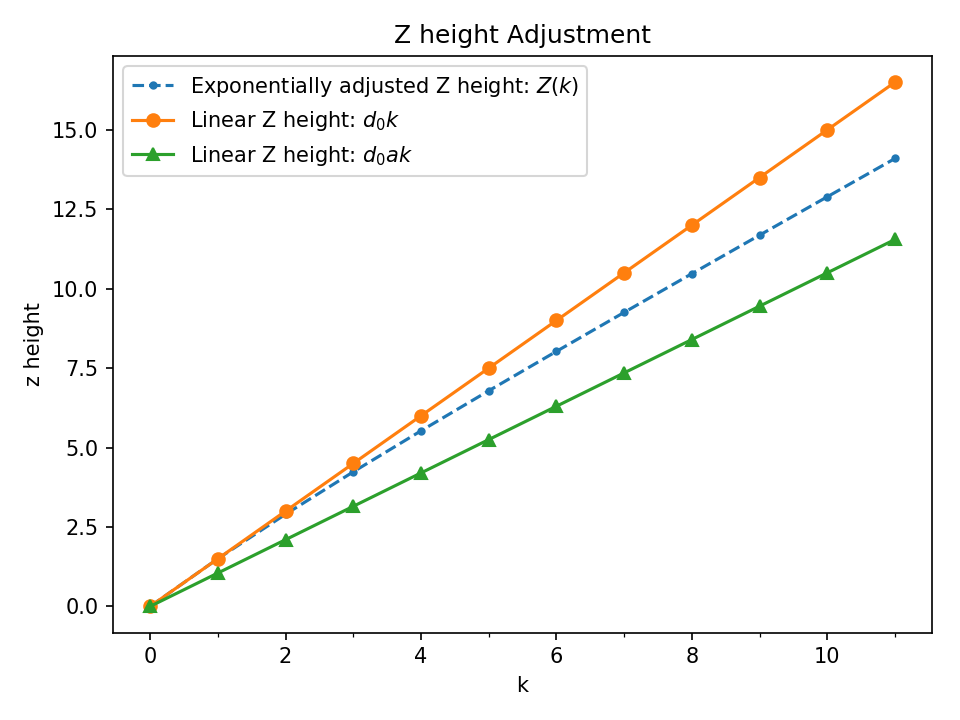

In [87]:
from matplotlib.ticker import AutoMinorLocator
num_layers = 12
layer_height =1.5
z_start = 0
k = np.arange(0,num_layers)
z_k = height_vector(num_layers,layer_height,z_start,a=0.8,b=0.4)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k,z_k,'.--', label='Exponentially adjusted Z height: $Z(k)$')
ax.plot(k,k*layer_height,'o-', label='Linear Z height: $d_0k$')
ax.plot(k,k*layer_height*0.7,'^-', label='Linear Z height: $d_0ak$')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))# minor ticks
ax.set_title('Z height Adjustment')
ax.set_xlabel('k')
ax.set_ylabel('z height')
plt.legend()
plt.tight_layout()
plt.savefig('Z height Adjustment.svg',bbox_inches='tight')
plt.savefig('Z height Adjustment.png',dpi=300)#,bbox_inches='tight')
plt.show()

In [25]:
# script to print points in the sprial
# current paramters work perfectly - print was succesfful 
# Feedrate of 800 is optimal for prefect print
# 16 Gauge tip was used
# 00-35 was used
# .4 precision on decimal places used in toolpath
import math
# intial parameters
center = [0,0]
# SKIN = 2 # defined in muscle_printing.py
# MUSCLE = 1
# CONDUCTIVE = 0
layer_height = d
layer_width = d
resolution = 25
z_start =3.8
num_layers = 40 # for height of x mm
cylinder_height = layer_height*num_layers

# Adjusting for sagging in z height
# d is vector containg the adjusted z height for each layer going up
d = height_vector(num_layers,layer_height,z_start)

# parameters for layer to cover entire diameter
k_full = 12 # will give a cylinder diamter of 40 mm
start_full = 0 

k_additional = 4
#paramters for layer to cover outer two circle of spiral
k_outside = 2
start_outside = (k_full-k_outside)*layer_width

base_layers = 1
lines_list_1 = [SKIN]
for i in range(num_layers-base_layers):
    if i==0:
        line = np.flip(spiral(center,d[i],k_full+k_additional,start_full,layer_width,resolution,SKIN)[1],0)
    elif i <= base_layers-1:        
        if i % 2 == 0:
            line = spiral(center,d[i],k_full,start_full,layer_width,resolution,SKIN)[1]
        elif i % 2 != 0:
#             line = np.flip(spiral(center,d[i],k_full,start_full,layer_width,resolution,SKIN)[1],0)
            line = spiral(center,d[i],k_full,start_full,layer_width,resolution,SKIN)[1]
            
#             line = spiral(center,d[i],k_full,start_full,layer_width,resolution,SKIN,reverse=True)[1]
            
    else:
        if i % 2 != 0:
            line = spiral(center,d[i],k_outside,start_outside,layer_width,resolution,SKIN,reverse=True)[1]
        if i % 2 == 0:
#             line = np.flip(spiral(center,d[i],k_outside,start_outside,layer_width,resolution,SKIN)[1],0)
            line = spiral(center,d[i],k_outside,start_outside,layer_width,resolution,SKIN,reverse=True)[1]
#             line = spiral(center,d[i],k_outside,start_outside,layer_width,resolution,SKIN,reverse=True)[1]
            
            
    lines_list_1.append(line)
#lines_list = [lines_list]

# Muscle extrusion
# do same spiral motion for same number of layers but don't change the z height
k_middle = k_full - k_outside - 2
start_middle = 0
lines_list_2 = [MUSCLE]
for i in range(num_layers-base_layers-base_layers-1):
    print(i)
    if i == 0:
        line = spiral(center,d[num_layers-base_layers],k_middle,start_middle,layer_width,resolution,MUSCLE)[1]
    elif i % 2 == 0: 
        line = spiral(center,d[num_layers-base_layers],k_middle,start_middle,layer_width,resolution,MUSCLE)[1]
    elif i % 2 != 0: 
        line = np.flip(spiral(center,d[num_layers-base_layers],k_middle,start_middle,layer_width,resolution,SKIN)[1],0)
    lines_list_2.append(line)
    
# top layer - skin
lines_list_3 = [SKIN]
for i in range(num_layers-base_layers,num_layers):
    if i % 2 == 0:
        line = spiral(center,d[i],k_full,start_full,layer_width,resolution,SKIN)[1]
    elif i % 2 != 0:
        line = np.flip(spiral(center,d[i],k_full,start_full,layer_width,resolution,SKIN)[1],0)
    lines_list_3.append(line)


# for i in range()

lines_list = [lines_list_1,lines_list_2,lines_list_3]
# lines_list = [lines_list_1,lines_list_2]
# lines_list = [lines_list_1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


<IPython.core.display.Javascript object>


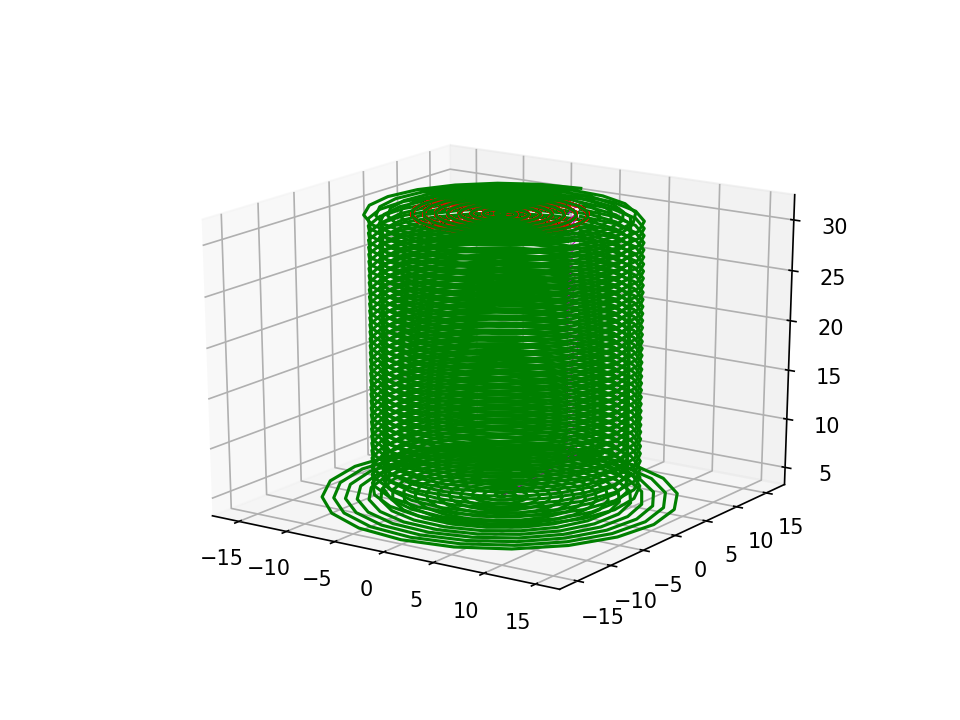

In [26]:
%matplotlib notebook
plot_lines_list(lines_list)

In [27]:
# """check total extusion value for each extruder"""
# from re import split
# # re.findall('[-+]?\d*\.\d+|\d+', 'G1 E-0.0151:-0.0000:-0.0151:-0.0000:5')
# def check_total_extrusion(gcode):
#     e_list = []
#     for line in gcode.split('\n'):
#         try:
#             e_list.append([float(x) for x in split(':',split(' ',split('E',line)[-1])[0])])
#         except ValueError:
#             pass
#     e_list = np.array(e_list)
#     return np.sum(e_list,axis=0)
# f = open('D:/Google Drive/3D printing soft muscle/G-Code/spiral.g','r')
# message = f.read()
# # print(message)
# f.close()
# total_extrusion = check_total_extrusion(message)
# # print('G1 E-{0:0.4f}:-{1:0.4f}:-{2:0.4f}:-{3:0.4f} F300\n'.format(total_extrusion[0],total_extrusion[1],total_extrusion[2],total_extrusion[3]))
# print(total_extrusion)

In [143]:
g_code_strings = lines_list_to_gcode_strings(lines_list,gcode_para)
# dumping:
#g_code_strings.insert(0,'G0 X-200.0000 Y-200.0000 Z15.0000 F1500\nG1 F0.4624\nG1 E0:0:0:0 F0.4624\nG1 E0:9:9:0 F0.4624\nG4 P6000\nG0 F1800')

g_code_strings.insert(0,'G0 X-200.0000 Y-200.0000 Z15.0000 F1500\nG1 F{0:.3f}\nG1 E0:0:0:0\nG1 E0:9:9:0\nG4 P15000\nG0 F1800\n'.format(gcode_para['feedrate_extrude']))

# only skin:
# g_code_strings.insert(0,'G0 X-200.0000 Y-200.0000 Z15.0000 F1500\nG1 F0.4624\nG1 E0:0:0:0 F0.4624\nG1 E0:8:8:0 F0.4624\nG4 P6000\nG0 F1800')



# initialization
init = initilize_parameters(4,is_absolute=True,is_mm=True,feedrate = 1500 )
g_code_strings.insert(0,init)


s = ''.join(g_code_strings)
# f = open('/Users/davidjoseph/Google Drive/3D printing soft muscle/G-Code/spiral.g','w')
f = open('D:/Google Drive/3D printing soft muscle/G-Code/spiral.g','w')
f.write(s)
f.close()
print(s)

2
1
2
T4
G90
G21
G0 F1500
M83
G0 X-200.0000 Y-200.0000 Z15.0000 F1500
G1 F0.102
G1 E0:0:0:0
G1 E0:9:9:0
G4 P15000
G0 F1800
G1 X0.000000 Y15.840000 Z3.800000 F1500
G1 X-4.894272 Y15.012698 Z3.800000 E0.000000:0.004750:0.004750:0.000000 F550
G1 X-9.277210 Y12.716237 Z3.800000 E0.000000:0.004735:0.004735:0.000000 F550
G1 X-12.721507 Y9.185413 Z3.800000 E0.000000:0.004720:0.004720:0.000000 F550
G1 X-14.894761 Y4.774814 Z3.800000 E0.000000:0.004705:0.004705:0.000000 F550
G1 X-15.591535 Y-0.076775 Z3.800000 E0.000000:0.004690:0.004690:0.000000 F550
G1 X-14.752749 Y-4.890022 Z3.800000 E0.000000:0.004675:0.004675:0.000000 F550
G1 X-12.470553 Y-9.192399 Z3.800000 E0.000000:0.004660:0.004660:0.000000 F550
G1 X-8.978314 Y-12.564580 Z3.800000 E0.000000:0.004645:0.004645:0.000000 F550
G1 X-4.626787 Y-14.681297 Z3.800000 E0.000000:0.004631:0.004631:0.000000 F550
G1 X0.151104 Y-15.342704 Z3.800000 E0.000000:0.004616:0.004616:0.000000 F550
G1 X4.883332 Y-14.493212 Z3.800000 E0.000000:0.004601:0.004601